In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as sci
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linreg = LinearRegression()
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
# from tbats import TBATS

In [78]:
data = pd.read_csv('https://raw.githubusercontent.com/dbreitner12/dsc-v2-mod1-final-project-nyc-ds-060319/master/kc_house_data.csv')


In [79]:
income = pd.read_csv('../../zipcode_income.csv')

In [80]:
income.dtypes

zipcode                 int64
median_income_2014    float64
mean_income_2014      float64
dtype: object

In [81]:
#New Columns
data['house_age'] = 2019 - data.yr_built
data['sqft_living_compare'] = data.sqft_living / data.sqft_living15
data['price_log'] = np.log(data.price)

#Standardize Data - View, Condition, Grade
data['view_stand'] = (data.view - data.view.mean()) / data.view.std()
data['condition_stand'] = (data.condition - data.condition.mean()) / data.condition.std()
data['grade_stand'] = (data.grade - data.grade.mean()) / data.grade.std()

#Clean Data
data.yr_renovated.fillna(0, inplace = True)
data.sqft_basement[data.sqft_basement == '?'] = data.sqft_living - data.sqft_above
data.sqft_basement = pd.to_numeric(data.sqft_basement)

#Drop Outliers
data.drop(data.index[[1717, 3910, 7245, 8537, 12764, 15856]], inplace=True)

#Zipcode Distribution and Median
zip_medians = pd.DataFrame((data.groupby(data.zipcode).price_log.median()-data.price_log.median())/data.price_log.std())
zip_medians.columns = ['zipcode_price']
data = data.merge(zip_means, on='zipcode')
data['zipcode_rank'] = pd.cut(data.zipcode_price, 5, labels=["low", "medium_low", "medium", "medium_high", "high"])
zipcode_dummies = pd.get_dummies(data,'zipcode_rank', drop_first=True)
data = pd.concat([data.reset_index(drop=True), zipcode_dummies.iloc[:,-4:]], axis=1)

#Check if waterfront Nan are significant
test_DataFrame = data.loc[:, ['price_log', 'waterfront']]
test_DataFrame.waterfront = test_DataFrame.waterfront * 0
test_DataFrame.fillna(1, inplace = True)
test_DataFrame = pd.get_dummies(test_DataFrame,'waterfront', drop_first=True)

#format date column as datetime 
data['date'] = pd.to_datetime(data.date)

#Bedroom Dummies
bedrooms_dummies = pd.get_dummies(data.bedrooms, drop_first=True, prefix = 'Bedrooms') 
bedrooms_dummies['Bedrooms_7plus'] = bedrooms_dummies.Bedrooms_7 + bedrooms_dummies.Bedrooms_8 \
+ bedrooms_dummies.Bedrooms_9  +bedrooms_dummies.Bedrooms_10 +bedrooms_dummies.Bedrooms_11
bedrooms_dummies.drop(['Bedrooms_7', 'Bedrooms_8', 'Bedrooms_9', 'Bedrooms_10', 'Bedrooms_11'], axis = 1, inplace = True)
data = pd.concat([data.reset_index(drop=True), bedrooms_dummies], axis=1)

#Floor Dummy
floors_dummies = pd.get_dummies(data.floors, drop_first=True, prefix = 'Floors')
data = pd.concat([data.reset_index(drop=True), floors_dummies], axis=1)
data.rename(columns={'Floors_1.5':'floors1_5', 'Floors_2.0':'floors2','Floors_2.5':'floors2_5'\
                   ,'Floors_3.0':'floors3','Floors_3.5':'floors3_5'}, inplace=True)

#Seasonal 
data['quarter'] = data.loc[:,'date'].dt.quarter
quarter_dummies = pd.get_dummies(data.quarter, drop_first=True)
quarter_dummies.columns = ['Q2', 'Q3','Q4']
data = data.join(quarter_dummies)

data.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


AttributeError: 'DataFrame' object has no attribute 'zipcode_price'

In [82]:
# #New data of means of each day sale

# timeseries = data.groupby('date').price.mean()
# timeseries = pd.DataFrame(timeseries)

# # timeseries = timeseries.set_index(timeseries.date)

# # y = timeseries.price
# # estimator = TBATS(seasonal_periods=(12, 93))
# # model = estimator.fit(y)
# # print(model.summary())

# y = timeseries.price
# estimator = TBATS(seasonal_periods=(31, 12))
# model = estimator.fit(y)
# print(model.summary())

In [83]:
#format date column as datetime 
data['date'] = pd.to_datetime(data.date)

#Seasonal 
data['quarter'] = data.loc[:,'date'].dt.quarter
quarter_dummies = pd.get_dummies(data.quarter, drop_first=True)
quarter_dummies.columns = ['Q2', 'Q3','Q4']
data = data.join(quarter_dummies)

In [84]:
#Create new data of duplicates
dups = pd.DataFrame(data[data.id.duplicated(keep=False)])
#Find percent change in price
dups.sort_values(by=['id','date']).groupby(dups.id).price.pct_change().sort_values(ascending=False) 

4917     4.900621
7838     4.330396
13616    3.218009
14294    3.072289
1462     2.379464
11350    2.315385
15797    2.308271
14354    1.969697
4073     1.822581
10243    1.764706
6365     1.762295
8268     1.681707
12053    1.681542
2562     1.592000
19321    1.536087
17567    1.444444
12327    1.371429
11050    1.326531
8334     1.319149
5587     1.318182
13744    1.311561
6897     1.280000
14842    1.277916
15643    1.261905
9866     1.249166
2501     1.211538
9431     1.205403
12366    1.176636
9712     1.130984
15133    1.122449
           ...   
15454   -0.678899
324     -0.688591
10210   -0.688940
17119   -0.692982
9480    -0.694127
9007    -0.700654
19320   -0.710084
10904   -0.715000
15142   -0.715966
18549   -0.720315
17588   -0.733179
13010   -0.733285
15796   -0.741748
10215   -0.746753
6713    -0.760294
17052   -0.760676
15351   -0.767788
2629    -0.770845
12365   -0.774737
18688   -0.800000
9810    -0.801600
8267    -0.809302
8333    -0.832143
5718    -0.832174
10242   -0

In [85]:
len(data)

21591

In [86]:
bc_price_log, price_log_lambda = stats.boxcox(data.price_log)
bc_sqft_living, sqft_living_lambda = stats.boxcox(data.sqft_living)
bc_sqft_above, sqft_above_lambda = stats.boxcox(data.sqft_above)
bc_bedrooms, bedrooms_lambda = stats.boxcox(data.bedrooms)
bc_bathrooms, bathrooms_lambda = stats.boxcox(data.bathrooms)
bc_sqft_lot, sqft_lot_lambda = stats.boxcox(data.sqft_lot)
bc_floors, floors_lambda = stats.boxcox(data.floors)
bc_sqft_living15, sqft_living15_lambda = stats.boxcox(data.sqft_living15)
bc_sqft_lot15, sqft_lot15_lambda = stats.boxcox(data.sqft_lot15)
bc_house_age, house_age_lambda = stats.boxcox(data.house_age)

In [87]:
data_trans = pd.DataFrame({'id':data.id, 'date':data.date, 'waterfront':data.waterfront, 'zipcode':data.zipcode, 'lat':data.lat,\
              'long':data.long, 'view_stand': data.view_stand, 'condition_stand':data.condition_stand, 'grade_stand':data.grade_stand,\
             'zipcode_rank_medium_low':data.zipcode_rank_medium_low, 'zipcode_rank_medium':data.zipcode_rank_medium,\
              'zipcode_rank_medium_high':data.zipcode_rank_medium_high, 'zipcode_rank_high':data.zipcode_rank_high,\
              'price_log':data.price_log, 'sqft_living':bc_sqft_living, 'sqft_above':bc_sqft_above, 'bedrooms':bc_bedrooms,
              'bathrooms':bc_bathrooms, 'sqft_lot':bc_sqft_lot, 'floors':bc_floors, 'sqft_living15': bc_sqft_living15,\
             'sqft_lot15':bc_sqft_lot15, 'house_age':bc_house_age})

AttributeError: 'DataFrame' object has no attribute 'zipcode_rank_medium_low'

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Before Log Transformation')

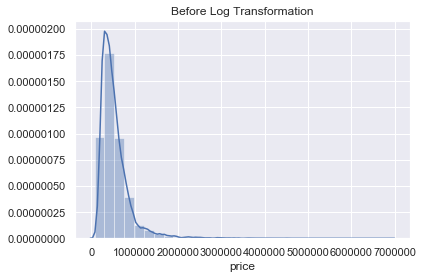

In [47]:
#Histograms
sns.distplot(data['price'], bins = 30).set_title('Before Log Transformation')

Text(0.5, 1.0, 'Floor Distribution')

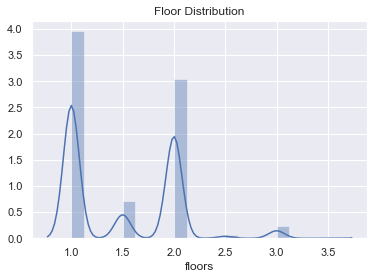

In [55]:
sns.distplot(data['floors'], bins = 20).set_title('Floor Distribution')

In [2]:
sns.scatterplot(data.price_log, data.bedrooms)

NameError: name 'sns' is not defined

In [1]:
#Heatmap
house_predictors = data
corr = house_predictors.corr()
sns.heatmap(corr,cmap = 'seismic', linecolor = 'black', linewidths = .1)

NameError: name 'data' is not defined

In [ ]:
sns.jointplot(x='yr_built'  , y='price_log' , data = data, kind ='reg' )

In [ ]:
data.columns

In [63]:
f = 'price_log~Q2+Q3+Q4+sqft_living'
model = ols(formula=f, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     5083.
Date:                Fri, 21 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:09:57   Log-Likelihood:                -9593.1
No. Observations:               21591   AIC:                         1.920e+04
Df Residuals:                   21586   BIC:                         1.924e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2070      0.008   1483.754      0.000      12.191      12.223
Q2              0.0329      0.007      4.414      0.000       0.018       0.048
Q3             -0.0022      0.008     -0.285      0.775      -0.017       0.013
Q4             -0.0161      0.008     -2.001      0.045      -0.032      -0.000
sqft_living     0.0004   2.82e-06    142.296      0.000       0.000       0.000
==============================================================================
Omnibus:                       46.377   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.888
Skew:                           0.050   Prob(JB):                     2.18e-09
Kurtosis:                       2.815   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
f = 'price_log~zipcode_rank_medium_low+zipcode_rank_medium+zipcode_rank_medium_high+zipcode_rank_high\
                +view_stand+condition_stand+grade_stand+sqft_living+waterfront+sqft_lot'
model = ols(formula=f, data=data).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'zipcode_rank_medium_high' is not defined
    price_log~zipcode_rank_medium_low+zipcode_rank_medium+zipcode_rank_medium_high+zipcode_rank_high                +view_stand+condition_stand+grade_stand+sqft_living+waterfront+sqft_lot
                                                          ^^^^^^^^^^^^^^^^^^^^^^^^

In [88]:
f = 'price_log~+zipcode_rank_medium_low+zipcode_rank_medium+zipcode_rank_medium_high+zipcode_rank_high\
               +view_stand+condition_stand+grade_stand+sqft_living+waterfront + sqft_lot'
model_trans = ols(formula=f, data=data_trans).fit()
model_trans.summary()

NameError: name 'data_trans' is not defined

In [89]:
#Lambda Transformation
def lambda_trans(x, lmbda):
    if lmbda == 0:
        return exp(x) 
    else:
        return ((lmbda)*(x + 1))**(1/lmbda)

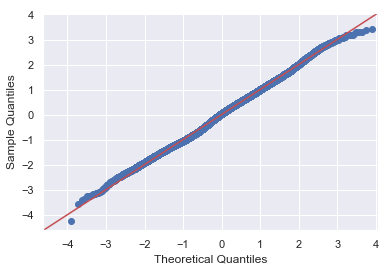

In [90]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

In [91]:
residuals = model_trans.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

NameError: name 'model_trans' is not defined

In [92]:
#Visualize Error Terms
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_lot' , fig=fig)
plt.show()

ValueError: 'sqft_lot' is not in list

<Figure size 1080x576 with 0 Axes>

In [93]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_trans, 'sqft_lot' , fig=fig)
plt.show()

NameError: name 'model_trans' is not defined

<Figure size 1080x576 with 0 Axes>

In [ ]:
# Drop Nan
data.dropna(inplace = True)

In [ ]:
len(data)

In [64]:
f = 'price_log~zipcode_rank_medium_low+zipcode_rank_medium+zipcode_rank_medium_high+zipcode_rank_high\
               +view_stand+condition_stand+grade_stand+sqft_living+waterfront + sqft_lot'

In [ ]:
data = pd.concat([data.price_log,data.zipcode_rank_medium_low,data.zipcode_rank_medium, data.zipcode_rank_medium_high,data.zipcode_rank_high\
               ,data.view_stand, data.condition_stand, data.grade_stand, data.sqft_living, data.waterfront, data.sqft_lot\
                        ,data.sqft_living, data.bedrooms, data.bathrooms], axis= 1)
y = data[['price_log']]
X = data.drop(['price_log'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [ ]:
data_trans.columns

In [ ]:
f = 'price_log~waterfront*view_stand+grade_stand+sqft_living+ zipcode_rank_medium_low\
       + zipcode_rank_medium + zipcode_rank_medium_high + zipcode_rank_high'
model_trans = ols(formula=f, data=data_trans).fit()
model_trans.summary()

In [ ]:
def mean_log_squared_error(y_test, preds):
    total = 0
    for ys in list(zip(y_test, preds)):
        diff = np.exp(ys[0]) - np.exp(ys[1])
        total += diff**2
    mlse_squared = total/len(y_test)
    return np.sqrt(mlse_squared)

preds = linreg.predict(X_test)
mean_log_squared_error(y_test.values, preds)

In [ ]:
data_trans.dropna(inplace = True)

In [ ]:
#Cross Validation
data_trans = pd.concat([data_trans.price_log,data_trans.zipcode_rank_medium_low,data_trans.zipcode_rank_medium, data_trans.zipcode_rank_medium_high,data_trans.zipcode_rank_high\
               ,data_trans.view_stand, data_trans.condition_stand, data_trans.grade_stand, data_trans.sqft_living, data_trans.waterfront, data_trans.sqft_lot\
                        ,data_trans.sqft_living, data_trans.bedrooms, data_trans.bathrooms], axis= 1)
y = data_trans[['price_log']]
X = data_trans.drop(['price_log'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();